<a href="https://colab.research.google.com/github/jamesgolden1/llms-are-llms/blob/main/notebooks/detached_jacobian_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Llama 3.2 3B IT with the detached Jacobian is locally linear
This notebook demonstrates how to compute the Jacobian in PyTorch (other demos apply this code within the JacobianAnalyzer class).

In [ ]:
%%capture
!pip install "huggingface_hub[hf_transfer]"

In [ ]:
import os
from google.colab import userdata

os.environ["HF_HUB_ENABLE_HF_TRANSFER"]='1'
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
!git clone https://github.com/jamesgolden1/llms-are-llms.git

Cloning into 'llms-are-llms'...
remote: Enumerating objects: 1109, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 1109 (delta 107), reused 74 (delta 34), pack-reused 921 (from 1)
Receiving objects: 100% (1109/1109), 51.43 MiB | 11.43 MiB/s, done.
Resolving deltas: 100% (628/628), done.


In [ ]:
cd llms-are-llms

/content/llms-are-llms


In [ ]:
#@title Copy modeling_llama_locally_linear.py into transformers
import shutil
import transformers
transformers_file = transformers.__file__.split('__')[0]

# Llama 3.1
modeling_file_new = "models/llama_3/modeling_llama_locally_linear.py"
modeling_file = transformers_file+"models/llama/modeling_llama.py"
backup_file = transformers_file+"models/llama/modeling_llama_original.py"
shutil.copy(modeling_file, backup_file)
shutil.copy(modeling_file_new, modeling_file)

'/usr/local/lib/python3.11/dist-packages/transformers/models/llama/modeling_llama.py'

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers.models.llama.modeling_llama import *
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
#@title Model
model_id = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = LlamaForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    # torch_dtype=torch.float32,
    device_map="auto",
).cuda()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#@title Get input embedding vectors with gradient and generate output
text = "The bridge out of Marin is the"

tokenizer.pad_token = tokenizer.eos_token
inputs = tokenizer([text],padding=True, return_tensors="pt")

inputs = {k: v.to('cuda') for k, v in inputs.items() if k != 'token_type_ids'}

model.eval()
outputs = model.generate(
                          **inputs,
                          max_new_tokens=1,
                          return_dict_in_generate=True,
                          output_scores=True,
                          past_key_values=None,
                          use_cache=False,
                          output_hidden_states=True,
                          temperature=.001)
print("[", [tokenizer.decode(outputs['sequences'][ii]) for ii in range(len(outputs['sequences']))], "]")

embeds = model.model.embed_tokens(tokenizer.encode(text, return_tensors='pt').cuda())

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[ ['<|begin_of_text|>The bridge out of Marin is the most'] ]


In [ ]:
#@title Function to predict output embedding for Jacobian comptuation
def llama_forward(embeds):
    # print(model.training)
    position_ids = torch.arange(embeds.shape[1], device=embeds.device).unsqueeze(0).expand(1, -1)
    cos, sin = model.model.rotary_emb(embeds, position_ids)
    position_embeddings = (cos, sin)
    out = model.model.layers[0](embeds, position_ids=position_ids, position_embeddings=position_embeddings)
    for ii in range(1,len(model.model.layers)):
        out = model.model.layers[ii](out[0], position_ids=position_ids, position_embeddings=position_embeddings)
    out = model.model.norm(out[0])
    return out[0][-1,:]

In [ ]:
#@title Verify forward function is the same as generate for train()
model.train();
torch.sum(torch.abs(outputs['hidden_states'][-1][-1][-1][-1]-llama_forward(embeds)))

tensor(0., device='cuda:0', dtype=torch.bfloat16, grad_fn=<SumBackward0>)

In [ ]:
#@title Verify forward function is the same as generate for eval()
model.eval();
torch.sum(torch.abs(outputs['hidden_states'][-1][-1][-1][-1]-llama_forward(embeds)))

tensor(0., device='cuda:0', dtype=torch.bfloat16, grad_fn=<SumBackward0>)

In [ ]:
#@title Compute Jacobian
%%time
model.eval();

# Get Jacobian matrices (one matrix for each input embedding vector)
jacobian = torch.autograd.functional.jacobian(llama_forward, embeds, vectorize=True,strategy="reverse-mode").squeeze()

# Sum(Jacobian_i*input_embedding_i) equals output
jacobian_by_token = torch.stack([torch.matmul(jacobian[:,ii,:],embeds[0,ii,:].squeeze())[:] for ii in range(jacobian.shape[1])])
jacobian_output = torch.sum(jacobian_by_token,dim=0)#.shape

CPU times: user 115 ms, sys: 23.2 ms, total: 138 ms
Wall time: 157 ms


In [ ]:
#@title Compare Jacobian reconstruction with output
linear_jacobian_output = jacobian_output
linear_jacobian_output_error = jacobian_output - outputs.hidden_states[-1][-1][0,-1]
outnplinear = linear_jacobian_output_error.cpu().detach().float().numpy()
xvalslin = outputs.hidden_states[-1][-1][-1][-1].cpu().detach().float().numpy()

For lowest Jacobian error, run at float32 precision on an A100. You can also run float32 on CPU on an L4 but it is slow.


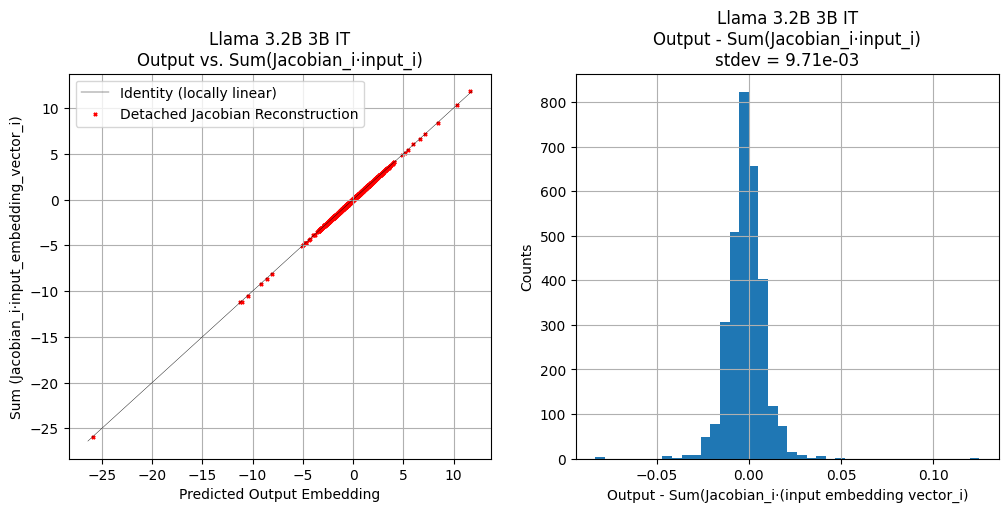

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
axs = axs.flat
print("For lowest Jacobian error, run at float32 precision on an A100. You can also run float32 on CPU on an L4 but it is slow.")
for n, ax in enumerate(axs):

    if n == 0:

        ax.plot([1.02*np.min(xvalslin), 1.02*np.max(xvalslin)], [1.02*np.min(xvalslin), 1.02*np.max(xvalslin)], 'k', linewidth=0.3)
        ax.scatter(xvalslin,(jacobian_output).cpu().detach().float().numpy(),5,'r',marker='x');

        ax.set_xlabel('Predicted Output Embedding')
        ax.set_ylabel('Sum (Jacobian_i·input_embedding_vector_i)')
        ax.legend(['Identity (locally linear)', 'Detached Jacobian Reconstruction'])
        ax.set_title('Llama 3.2B 3B IT\nOutput vs. Sum(Jacobian_i·input_i)')
        ax.grid()
    if n == 1:
        outnp = linear_jacobian_output_error.cpu().detach().float().numpy()
        ax.hist(outnp/np.std(outputs.hidden_states[-1][-1][-1][-1].cpu().detach().float().numpy()),bins=40)#,range=[-20,20])#,range=[-7.5e-6,7.5e-6]);
        ax.set_ylabel('Counts')
        ax.set_xlabel('Output - Sum(Jacobian_i·(input embedding vector_i)')
        ax.grid()
        ax.set_title('Llama 3.2B 3B IT\nOutput - Sum(Jacobian_i·input_i)\nstdev = '+"{val:1.2e}".format(val=np.std(outnp)/np.std(outputs.hidden_states[-1][-1][-1][-1].cpu().detach().float().numpy())))